### Importing modules

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

import torchvision.transforms as transforms

### defining the dataloader

In [34]:
def load_data_cifar10(batch_size, resize=None, data_augmentation=True):
    # Define transformations for data augmentation
    train_transforms = []
    if resize:
        train_transforms.append(transforms.Resize(resize))
    # performing data augmentation using horizontal flipping and rotation
    if data_augmentation:
        train_transforms.extend([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
           
        ])
    train_transforms.append(transforms.ToTensor())

    # Define transformations for testing/validation
    test_transforms = []
    if resize:
        test_transforms.append(transforms.Resize(resize))
    test_transforms.append(transforms.ToTensor())

    # Compose the transformations
    train_transform = transforms.Compose(train_transforms)
    test_transform = transforms.Compose(test_transforms)

    # Load the CIFAR-10 datasets with the specified transformations
    train_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=test_transform)

    # Initialize DataLoader instances for training and testing datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader
# Initialize the dataset loader
batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size, data_augmentation=True)


Files already downloaded and verified
Files already downloaded and verified


### displaying images

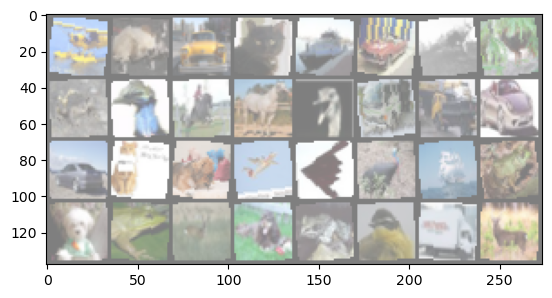

airplane                  cat                       automobile                cat                       ship                      automobile                airplane                  deer                      frog                      bird                      horse                     horse                     bird                      truck                     truck                     automobile                automobile                cat                       dog                       airplane                  airplane                  bird                      ship                      frog                      dog                       frog                      deer                      dog                       frog                      bird                      truck                     deer                     


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Define class labels for CIFAR-100
# Define class labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
images, labels = next(iter(train_iter))

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%-25s' % class_labels[labels[j]] for j in range(len(labels))))


### defining a class to create multiple intermediate blocks

In [36]:
# Define the intermediate block configuration as a class
class BlockConfig:
    def __init__(self, num_conv_layers, out_channels, kernel_size, padding, stride, 
                 pool_type=None, pool_kernel_size=None, pool_stride=None, dropout_prob=None):
        self.num_conv_layers = num_conv_layers
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.pool_type = pool_type
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.dropout_prob = dropout_prob


### defining the structure of the intermediate block

In [37]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, num_conv_layers, out_channels, kernel_size, padding, stride,
                 pool_type=None, pool_kernel_size=None, pool_stride=None, dropout_prob=None):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride) 
            for _ in range(num_conv_layers) # creating a class module list 
        ])
        self.relu = nn.ReLU() # creating an instance of the activation function
        self.pool_type = pool_type # assigning the specified value to the class variable 
        self.pool_kernel_size = pool_kernel_size # assigning the specified value to the class variable 
        self.pool_stride = pool_stride #assigning the specified value to the class variable 
        
        # Initialize pooling layer if configured
        if self.pool_type is not None:
            if self.pool_type == 'max':
                self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride)
            elif self.pool_type == 'avg':
                self.pool = nn.AvgPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride)
            else:
                raise ValueError("Invalid pooling type.")
        
        self.dropout = None
        if dropout_prob is not None:
            self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
            
        # assigning a fully connected layer
        self.fc = nn.Linear(in_channels, num_conv_layers) 
   #defining forward function
    def forward(self, x):
        outputs = [self.relu(conv(x)) for conv in self.conv_layers]
        outputs = torch.stack(outputs, dim=1) # stacking output from each convolution layer
        
        # Apply dropout if configured
        if self.dropout is not None:
            outputs = self.dropout(outputs)
        
        # Apply pooling if configured
        if self.pool_type is not None:
            batch_size, num_conv_layers, channels, height, width = outputs.size()
            outputs = outputs.view(batch_size * num_conv_layers, channels, height, width)
            outputs = self.pool(outputs)
            outputs = outputs.view(batch_size, num_conv_layers, channels, outputs.size(2), outputs.size(3))
   
        c_avg = x.mean(dim=[2, 3]) # channel averaging 
        weights_est = self.fc(c_avg)
        weights_est = weights_est.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        est_weighted_out = torch.sum(weights_est * outputs, 1)  # required computation for weights
        return est_weighted_out


### Defining the output block

In [38]:
# defining the output block
class OutputBlock(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.fc = nn.Linear(input_channels, num_classes)

    def forward(self, x):
        out = torch.mean(x, dim=(2, 3))  # Compute mean across height and width
        out = self.fc(out)
        return out

### Defining the model

In [39]:
class ClassificationModel(nn.Module):
    def __init__(self, in_chan, blockconfigs, num_classes=10):
        super(ClassificationModel, self).__init__()
        self.inter_block = nn.ModuleList([])
        for config in blockconfigs:
            self.inter_block.append(IntermediateBlock(in_chan, **config.__dict__))
            in_chan = config.out_channels
        
        self.bn = nn.BatchNorm2d(in_chan)  # creating an instace for batch normalisation
        self.output_block = OutputBlock(in_chan, num_classes)

    def forward(self, x):
        for block in self.inter_block:
            x = block(x)
            
        x = self.bn(x)  # Applying batch normalization
        output = self.output_block(x)
        return output


### Defining specifications for each block by calling the class

In [40]:
# spcecifying the required configurations per block
blockconfigs = [
    BlockConfig(num_conv_layers=4, out_channels=20, kernel_size=3, padding=0, stride=1,
                pool_type="avg", pool_kernel_size=1, pool_stride=1),
    BlockConfig(num_conv_layers=4, out_channels=60, kernel_size=3, padding=1, stride=1,pool_type="max",pool_kernel_size=1,pool_stride=1,dropout_prob=0.5),
    BlockConfig(num_conv_layers=4, out_channels=120, kernel_size=3, padding=1, stride=1,pool_type="avg",pool_kernel_size=1,pool_stride=1, dropout_prob=0.3),
    BlockConfig(num_conv_layers=4, out_channels=140, kernel_size=5, padding=1, stride=1,
                pool_type="max", pool_kernel_size=1, pool_stride=1, dropout_prob=0.5),
    BlockConfig(num_conv_layers=4, out_channels=160, kernel_size=3, padding=0, stride=1,
                pool_type="avg", pool_kernel_size=1, pool_stride=1)
]

# Initializing the model
model = ClassificationModel(3, blockconfigs, 10)


### Defining evaluation metrics

In [41]:
# Function to evaluate accuracy metric
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0., device=device)
    n = torch.tensor(0., device=device)

    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return c / n

# Function to calculate correct predictions
def correct(logits, y):
    y_hat = logits.argmax(axis=1)
    return (y_hat == y).float().sum()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training loop

In [42]:
losses = []
train_accs = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 40 # defining number of epochs
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        l = criterion(logits, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(float(l))

    train_acc = evaluate_metric(model, train_iter, correct)
    test_acc = evaluate_metric(model, test_iter, correct)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Training accuracy: {train_acc}. Testing accuracy: {test_acc}.')


Epoch 1/40.
Training accuracy: 0.5427600145339966. Testing accuracy: 0.5465999841690063.

Epoch 2/40.
Training accuracy: 0.636900007724762. Testing accuracy: 0.6367999911308289.

Epoch 3/40.
Training accuracy: 0.6813399791717529. Testing accuracy: 0.6807000041007996.

Epoch 4/40.
Training accuracy: 0.7110199928283691. Testing accuracy: 0.710099995136261.

Epoch 5/40.
Training accuracy: 0.7434200048446655. Testing accuracy: 0.7379999756813049.

Epoch 6/40.
Training accuracy: 0.7622399926185608. Testing accuracy: 0.7572000026702881.

Epoch 7/40.
Training accuracy: 0.7622799873352051. Testing accuracy: 0.7545999884605408.

Epoch 8/40.
Training accuracy: 0.7907000184059143. Testing accuracy: 0.7854999899864197.

Epoch 9/40.
Training accuracy: 0.8055400252342224. Testing accuracy: 0.7950999736785889.

Epoch 10/40.
Training accuracy: 0.8138399720191956. Testing accuracy: 0.8001000285148621.

Epoch 11/40.
Training accuracy: 0.8256000280380249. Testing accuracy: 0.8037999868392944.

Epoch 12/

# Plots

## loss for each batch

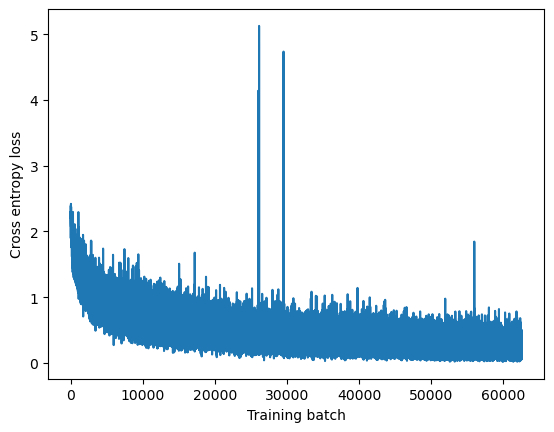

In [43]:
 plt.plot(losses) # Plots the loss for each training batch
 plt.xlabel('Training batch')
 plt.ylabel('Cross entropy loss')
 plt.show()

## plot for accuracy

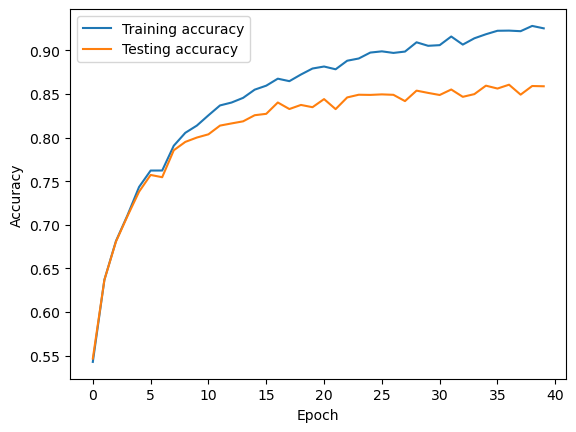

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'train_accs' and 'test_accs' are lists containing tensors
train_accs_cpu = [acc.cpu().item() for acc in train_accs]
test_accs_cpu = [acc.cpu().item() for acc in test_accs]

plt.plot(train_accs_cpu, label='Training accuracy')
plt.plot(test_accs_cpu, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


### printing the model


In [45]:
print(model)

ClassificationModel(
  (inter_block): ModuleList(
    (0): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-3): 4 x Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
      )
      (relu): ReLU()
      (pool): AvgPool2d(kernel_size=1, stride=1, padding=0)
      (fc): Linear(in_features=3, out_features=4, bias=True)
    )
    (1): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-3): 4 x Conv2d(20, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.5, inplace=False)
      (fc): Linear(in_features=20, out_features=4, bias=True)
    )
    (2): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-3): 4 x Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (relu): ReLU()
      (pool): AvgPool2d(kernel_size=1, stride=1, padding=0)
      (dropout): Dropout(p=0.3, inplace=False)
   

### printing out the number of parameters

In [46]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Print the number of parameters
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 2796282
Trainable parameters: 2796282


### references

Labs for answers of resnet and lecture notes of lecture 6 and 8